# Automatic Highlights Generator

Highlights Generator is an automated program which can be used to generate highlights of any
sports event. Sports coverage (live) as you know contains less exciting footages which might
not be of any value to an average audience who has to save time and also get the glimpse of
the sports event. In this situation, a Highlights Generator may be of much use as the audience
can generate short but important coverage of the whole event. This type of generator can be
implemented in many ways like NLP, DL, and CV. But our generator is fully based on Speech Analysis.

In [88]:
import ffmpeg
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time

#remove once in final
import subprocess

from matplotlib.mlab import window_hanning
from pathlib import Path
from scipy import signal
from scipy import stats

%matplotlib inline

In [89]:
# Constants
CWD = Path('.')
DUMP_DIR = CWD / "dump"
OUTPUT_DIR = CWD / "output"
SOURCE_DIR = CWD / "source"

# creates folders if not exists
DUMP_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)
SOURCE_DIR.mkdir(exist_ok=True)

# file descriptors
INPUT_FILENAME = "M31_KKR_v_RCB.mp4"
LENGTH_IN_SEC = 720
NO_OF_CHUNKS = 2000

INPUT_FILE = SOURCE_DIR / INPUT_FILENAME

In [3]:
# extraction of audio buffer and sampling rate
SAMPLE_RATE = int(ffmpeg.probe(INPUT_FILE)["streams"][1]["sample_rate"])

audio_buffer, _ = (ffmpeg
                   .input(INPUT_FILE)
                   .output('-', format='s16le', acodec='pcm_s16le', ac=1, ar=SAMPLE_RATE)
                   .overwrite_output()
                   .run(capture_stdout=True, quiet=True)
                  )

In [45]:
# conversion of buffer to array datatype for processing
audio_feed = np.frombuffer(audio_buffer, np.int16) / np.power(2, 15)

# determining the chunk size
audio_length = audio_feed.size // SAMPLE_RATE
chunk_size = audio_length // NO_OF_CHUNKS

673533952

In [30]:
# 128-point hanning filter to enhance speech frequency
hanning = signal.firwin(128, [300, 3500], nyq=0.5*SAMPLE_RATE,
                        pass_zero=False, window="hanning", scale=False)

# convolution to apply the filter throughout
audio_filtered = signal.convolve(audio_feed, hanning)

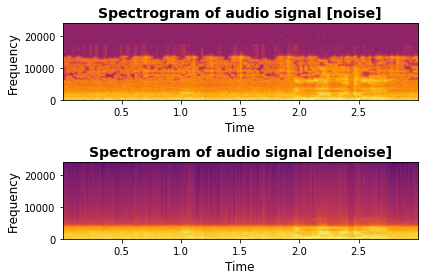

In [74]:
# comparison of audio signal before and after speech enhancement
plt.subplot(2, 1, 1)
plt.specgram(audio_feed[:chunk_size*SAMPLE_RATE], cmap="inferno", 
             Fs=SAMPLE_RATE, window=window_hanning)
plt.title("Spectrogram of audio signal [noise]", 
          fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Frequency", fontsize=12)


plt.subplot(2, 1, 2)
plt.specgram(audio_filtered[:chunk_size*SAMPLE_RATE], cmap="inferno", 
             Fs=SAMPLE_RATE, window=window_hanning)
plt.title("Spectrogram of audio signal [denoise]", 
          fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

Mean of energy is 0.009997156652615007
STD of energy is 0.003359512188478979
Energy between mean and 1sigma = 1327
Energy between 1sigma and 2sigma = 596
Energy between 2sigma and 3sigma = 73
Energy above 3sigma = 4


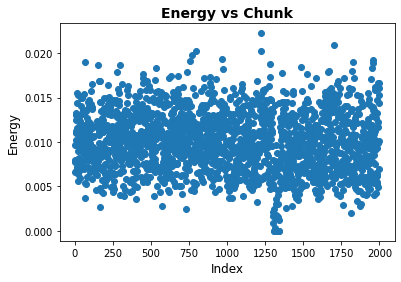

In [72]:
# energy computation per chunk
chunk_map = np.zeros(NO_OF_CHUNKS)
for i, chunk in enumerate(np.array_split(audio_filtered, NO_OF_CHUNKS)):
    chunk_map[i] = np.sum(chunk ** 2) / chunk.size

# stats analysis with chunks
std = stats.tstd(chunk_map)
mean = stats.tmean(chunk_map)
std1 = (abs(chunk_map - mean) < std).sum()
std2 = (abs(chunk_map - mean) < (2 * std)).sum() - std1
std3 = (abs(chunk_map - mean) < (3 * std)).sum() - std2 - std1
rest = NO_OF_CHUNKS - std3 - std2 - std1
print(f"Mean of energy is {mean}")
print(f"STD of energy is {std}")
print(f"Energy between mean and 1sigma = {std1}")
print(f"Energy between 1sigma and 2sigma = {std2}")
print(f"Energy between 2sigma and 3sigma = {std3}")
print(f"Energy above 3sigma = {rest}")

# plot of energy against index
plt.scatter(np.arange(0, NO_OF_CHUNKS), chunk_map)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Energy", fontsize=12)
plt.title("Energy vs Chunk", fontsize=14, fontweight="bold")
plt.show()

In [86]:
# thresholding chunk energy for events
qualified_chunks = {0, 1, (NO_OF_CHUNKS - 2), (NO_OF_CHUNKS - 1)}
for i, b in enumerate((abs(chunk_map[1:-1] - mean) > (2 * std)), 1):
    if b:
        qualified_chunks.update({(i - 1), i, (i + 1)})

# ordering chunk index
qualified_chunks = sorted(qualified_chunks)
print(f"No of chunks qualified is {len(qualified_chunks)}")

No of chunks qualified is 203


In [87]:
# detection of where to cut the videos
time_map = dict()
for i in qualified_chunks:
    start = i * chunk_size
    startts = time.strftime('%H:%M:%S', time.gmtime(start))
    n = 1
    while (i + 1) in qualified_chunks:
        n += 1
        i += 1
        qualified_chunks.remove(i)
    end = time.strftime('%H:%M:%S', time.gmtime(n * chunk_size))
    time_map[startts] = end

To be edited

In [92]:
def cut_videos(filename, timestamps):
    log = open("dump/order.txt", "w")
    for index, start in enumerate(timestamps, 1):
        subprocess.run(["ffmpeg", "-ss", start, "-i", filename, "-to", timestamps[start], "-c", "copy", "-avoid_negative_ts", "1", f"dump/{index}.mp4"])
        log.write(f"file '{index}.mp4'\n")
        
def merge_clips(filename):
    subprocess.run(["ffmpeg", "-f", "concat", "-i", "dump/order.txt", "-c", "copy", f"output/{filename}_highlights.mp4"])

In [93]:
cut_videos(INPUT_FILE, time_map)
merge_clips(INPUT_FILENAME)